# 🐧 The Evolution of Puffin's Population Regarding Climate Change

Welcome to the main Jupyter Notebook of our _Python project for Data Science_ ! 
Studying at the engineering school ENSAE, Institut Polytechnique de Paris, this project is part of the 2nd year course, under the supervision of Lino Galiana (Insee) and Romain Avouac (Insee). 

We share a passion for a clumsy but reaaaally cute seabird that is very common in Iceland : **the Atlantic puffin**. Unluckily, its demographic trend is downward. Well, it's not all by chance. Various high-qualited scientific studies have been carried out over the years to demonstrate the challenges facing this seabird species. Its biggest enemy to date is **climate change**, which is affecting its feeding (fish), reproduction and nesting. 

With this notebook, we set out to (re)demonstrate the causal link between global warming and the decline in the Atlantic puffin population. **The aim at the end of this page is to establish medium-term predictions for the evolution of this species, taking into account the different climate scenarios envisaged. Graphical visualization tools will support our modeling results.** 

Are you ready to see the disastrous consequences of climate change on such adorable birds? Let's get started! 
🐧🐧🐧🐧🐧🐧

## 💻 0. Setting up the work environment 

- data access through the cloud MinIO Client (files are in the folder 'diffusion')
- required packages 
- organizated environment 

In [34]:
!pip install -r requirements.txt # run this cell to install all the packages needed 

654.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [35]:
#import of libraries 

import os
import webbrowser
import s3fs
import matplotlib
import subprocess




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import plotly.graph_objects as go
import calendar

import contextily as ctx
import folium
from folium import LayerControl
import geopandas as gpd

from shapely.geometry import Polygon, LineString, Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset
from IPython.display import display

In [36]:
# Creation of two folders to centralize data and results
data_dir = "./data"  
os.makedirs(data_dir, exist_ok=True) 
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)


# Access information to the cloud MinIO Client (Eve's bucket)
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "esam"


## 🔗 1. Installing databases

As mentioned in the README, our data comes from : 
- **APIs** for climate data from Copernicus 
- **download free data** from scientific articles on the Internet 
- **free requests** to BirdLife International for access to puffin geographical data, sent by e-mail or via our account (with identification and verification procedure) on their platform. 

In order to provide **easy and secure access to this data for anyone wishing to run our code**, we have made it available on a _MinIO Client cloud_. 
You can access the entire bucket construction process on this Notebook : [Go to get_data Notebook](get_data.ipynb)

Otherwise, we'll be calling our data from our cloud (using s3fs) all through this notebook script. 

## ☞ What's next ? 

The rest of the project is divided into several stages: 
- data cleaning, data visualization and understanding
- modeling

During the visualization phase, we'll be observing the distribution of puffins in space, as well as changes in sea surface temperature (which will be the main explanatory variable). 
Then, we'll try to take the puffin reproduction rate as a demographic proxy for the species (based on the methodology of the article by ...) in order to predict the evolution of the species as a function of climate change through different estimation and prediction models. 

# Part 1 : Visualization 

## 🗺️ 1. Map visualization of Atlantic puffin distribution worldwide 

The Atlantic puffin is a migratory bird of the North Atlantic and Arctic polar zones. BirdLife International's data enable us to visualize the presence of these birds across the globe. 

### 1.1 MinIO Client cloud data retrieval and overview

_Nota bene : Having encountered difficulties working with files directly in S3 streams (shapefile, .nc, etc.), it is preferable to download files directly from the MinIO Client locally, to ensure optimal operation of the pandas and geopandas ecosystems, which is what the following program does._ 

In [37]:
# Creation of a subfolder to store Shapefile files and downloading of needed files
local_shapefile_subfolder = os.path.join(data_dir, "local_shapefile_files")
os.makedirs(local_shapefile_subfolder, exist_ok=True)

shapefile_elements = ["F_arctica.shp", "F_arctica.shx", "F_arctica.dbf"]
for element in shapefile_elements:
    remote_path = f"{MY_BUCKET}/diffusion/puffin_data/{element}"
    local_path = os.path.join(local_shapefile_subfolder, element)
    with fs.open(remote_path, "rb") as remote_file:
        with open(local_path, "wb") as local_file:
            local_file.write(remote_file.read())

# Lecture of the main shapefile file
local_shapefile_path = os.path.join(local_shapefile_subfolder, "F_arctica.shp")
gdf = gpd.read_file(local_shapefile_path)

### 2.2 Preparing files for graphical display

Geographic data and geometries must be correctly parameterized to be correctly displayed on a map.
The 'Coordinate Reference System' (CRS) EPSG:4326 displays geographic coordinates based on longitude and latitude. Its main uses are : 
- satellite data 
- global cartography 
- geographic data reference system

In [38]:
# Correction of the CRS to obtain the correct lecture of geographic coordinates
if gdf.crs != "EPSG:4326":
    print("The initial CRS is :", gdf.crs)
    gdf = gdf.set_crs(epsg=4326)
    print("The CRS has been redefined as EPSG:4326.")

# Simplification of the geometries
#if len(gdf) > 1000:  # Par exemple, pour les fichiers volumineux
gdf["geometry"] = gdf["geometry"].simplify(tolerance=0.01)
print("Geometries have been simplified.")

# Conversion to 2D geometries
def convert_to_2d(geom):
    if geom is not None and geom.has_z:
        return geom.simplify(0)  # Suppression de la dimension Z
    return geom

gdf["geometry"] = gdf["geometry"].apply(convert_to_2d)

# Checking of validated geometries
invalid_count = (~gdf.is_valid).sum()
print(f"Number of invalided geometries before correction : {invalid_count}")

# Correction of invalided geometries
if invalid_count > 0:
    gdf["geometry"] = gdf["geometry"].buffer(0)

The initial CRS is : None
The CRS has been redefined as EPSG:4326.
Geometries have been simplified.
Number of invalided geometries before correction : 2


### 2.3 Creation of a reactive folium map to visualize the worldwide presence of Atlantic puffins.

The Atlantic puffin lives on the high seas all year round, but returns to land when it breeds. This map shows the areas of non-breeding and breeding of the species, using reference data from BirdLife International.

The detailed puffin observation databases we use are established in breeding areas. 

In [39]:
# Add a "seasonal_label" column to the GeoDataFrame before creating the layers
gdf['seasonal_label'] = gdf['seasonal'].replace({
    2: "Breeding area",
    3: "Non-breeding area"
})

# Select the zones
breeding_zones = gdf[gdf["seasonal"] == 2]
non_breeding_zones = gdf[gdf["seasonal"] == 3]

# Create the Folium map
m = folium.Map(location=[55, 0], zoom_start=3, tiles="CartoDB Positron")

# Function to create a GeoJSON layer
def create_folium_layer(gdf, name, color):
    return folium.GeoJson(
        gdf,
        name=name,
        tooltip=folium.GeoJsonTooltip(
            fields=["sci_name", "presence", "seasonal_label"],  # Use "seasonal_label"
            aliases=["Scientific name", "Presence", "Seasonal"], 
            localize=True,
        ),
        style_function=lambda feature: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
        },
    )

# Create the layers
breeding_layer = create_folium_layer(breeding_zones, "Breeding zones", "green")
non_breeding_layer = create_folium_layer(non_breeding_zones, "Non-breeding zones", "lime")

# Add the layers to the map
breeding_layer.add_to(m)
non_breeding_layer.add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

### 2.4 Display of the folium map

Two options are possible : 
- display the folium map in the Notebook 
    * concentrates all results in this single notebook 
    * considerably heavier
- generate a HTML link for the folder ./results and generate a local server from the terminal to open a web page 

In [40]:
# 1st option : Displaying the map in the notebook 
display(m)

In [41]:
# 2nd option : HTML Link 

m.save("./results/puffin_distribution_map.html")
print(f"{os.path.abspath('./results')}")

""" Run the next cell or Then, copy cell output and enter in the bash : 
cd <absolute path you just copy> 
python -m http.server 8000

A new web page should open. All you have to do is select the "puffin_distribution_map" ! 

If you accidentally close the web page, you can reopen it by typing in your terminal : 
python -m http.server 8000
"""

/home/onyxia/work/projet_python_2024_ENSAE/results


' Run the next cell or Then, copy cell output and enter in the bash : \ncd <absolute path you just copy> \npython -m http.server 8000\n\nA new web page should open. All you have to do is select the "puffin_distribution_map" ! \n\nIf you accidentally close the web page, you can reopen it by typing in your terminal : \npython -m http.server 8000\n'

In [42]:
import subprocess
import os

# Get the absolute path to the 'results' directory
directory_to_serve = os.path.abspath('./results')

# Run the HTTP server using subprocess in the background
subprocess.Popen(["python", "-m", "http.server", "8000"], cwd=directory_to_serve)

# Optionally, open the browser automatically
import webbrowser
webbrowser.open("http://localhost:8000")

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/opt/conda/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_runpy.py:159: RuntimeWarning: 'http.server' found in sys.modules after import of package 'http', but prior to execution of 'http.server'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 3710, in <module>
    main()
  File "/opt/conda/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 3695, in main
    globals = debugger.run(setup["file"], None, None, is_module)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/o

True

### 🧑‍💻 About local server... 
A **local server** is a web server environment that runs solely on your computer. It uses your machine as a “server” to deliver files, HTML content or web applications to a browser via a local URL (such as http://localhost:8000).
- localhost: A special address that refers to your own machine. 
- Port: A number used to distinguish different services on your machine. By default, a local server often uses port 8000 or 8080.

_Step 1: Launch a local server_
- Open a terminal and navigate to the directory containing your files.
- Run the following command:
    _python -m http.server 8000_

_Step 2: Access the server in a browser_
- Open a browser.
- Go to http://localhost:8000.
You'll see the files in the directory as if you were browsing a website.

Other informations:
- Limited access: here, the local server is only accessible from your own machine.
- Stop server: to stop it, press Ctrl+C in the terminal.
- Applications : web development (test sites or applications locally before deploying them online), data visualization (serve files such as Folium maps or interactive graphic). 

## 🌊🥵 2. What about climate change ? 

Let's have a look to our climate data from Copernicus. These will be used as an explanatory variable to study the evolution of puffins. 



### 2.1 Selection and visualization of the study area (Vestmann Islands, Iceland)

We selected a specific area where data on the puffin population is available. This area is located in the Vestmannaeyjar (Vestmann Islands), an archipelago situated south of Iceland, home to 2 to 4 billion puffins.

If you would like to visualize the Vestmann Islands, run the next cell.

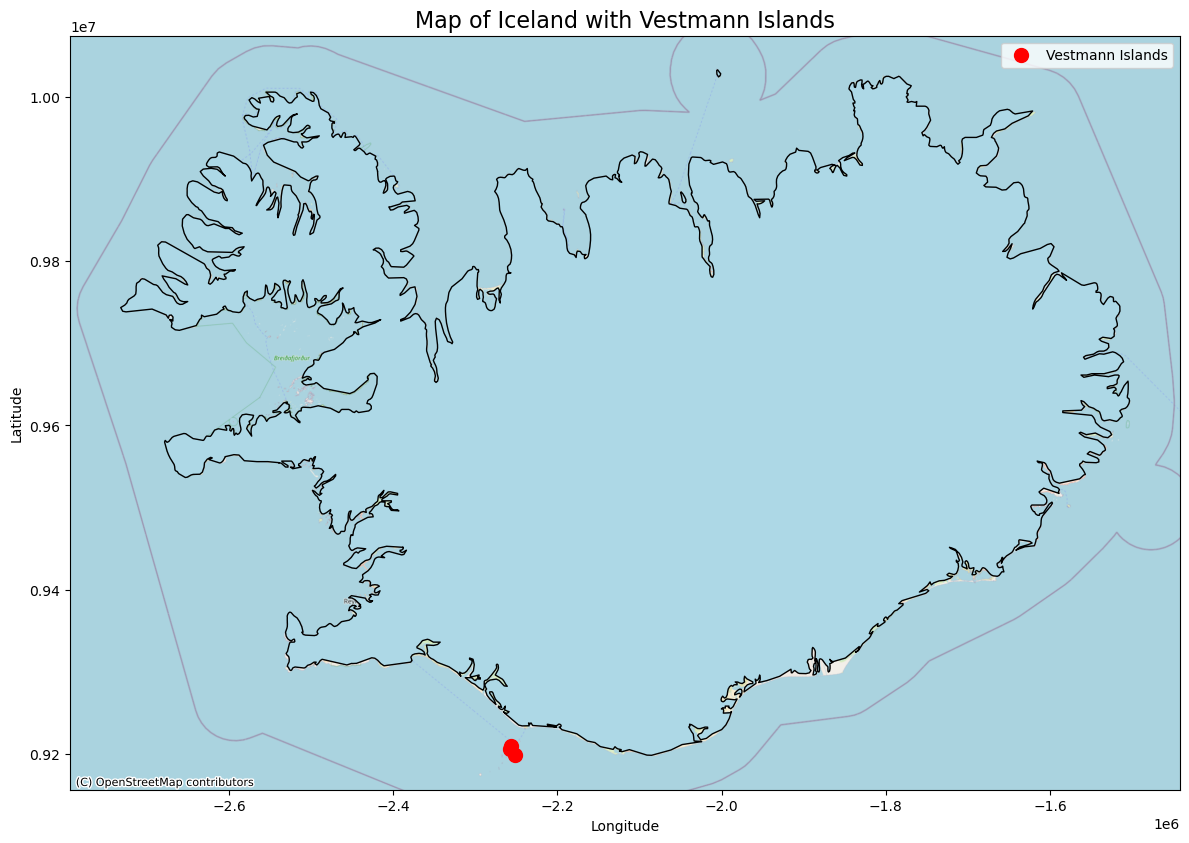

In [43]:
# Load a high-resolution shapefile for Iceland
# Use a freely available shapefile for country boundaries
url = "https://github.com/datasets/geo-countries/raw/main/data/countries.geojson"
world = gpd.read_file(url)

# Filter for Iceland
iceland = world[world['ADMIN'] == 'Iceland']

# Define the coordinates of the Vestmann Islands
vestmann_islands_coords = [
    (63.441, -20.273),  # Heimaey
    (63.426, -20.285),  # Elliðaey
    (63.396, -20.225),  # Bjarnarey
]

# Convert the Vestmann Islands' coordinates into a GeoDataFrame
vestmann_gdf = gpd.GeoDataFrame(
    {
        'Name': ['Heimaey', 'Elliðaey', 'Bjarnarey'],
        'Coordinates': vestmann_islands_coords,
    },
    geometry=gpd.points_from_xy(
        [coord[1] for coord in vestmann_islands_coords],  # Longitude
        [coord[0] for coord in vestmann_islands_coords],  # Latitude
    ),
    crs="EPSG:4326",  # Set the coordinate reference system to WGS 84
)

# Create a better map with contextily basemap
fig, ax = plt.subplots(figsize=(12, 12))
# Plot Iceland's boundaries
iceland = iceland.to_crs(epsg=3857)  # Reproject to Web Mercator for basemap compatibility
iceland.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=1)

# Plot the Vestmann Islands
vestmann_gdf = vestmann_gdf.to_crs(epsg=3857)  # Reproject to match Iceland's CRS
vestmann_gdf.plot(ax=ax, color="red", markersize=100, label="Vestmann Islands")

# Add a basemap from contextily (OpenStreetMap tiles)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)

# Customize the map
plt.title("Map of Iceland with Vestmann Islands", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()

# Show the map
plt.show()

We can also create another folium map to have more reactive visualization tools. 
By running the cell above, you can create a new layer which indicate Vestmann Islands. The map is automatically added to your local server once it is available. 

In [44]:
# Define the coordinates of the Vestmann Islands
vestmann_islands_coords = [
    (63.441, -20.273),  # Heimaey
    (63.426, -20.285),  # Elliðaey
    (63.396, -20.225),  # Bjarnarey
]

# Create a new map or use the existing one
m = folium.Map(location=[63.4, -20.25], zoom_start=10, tiles="OpenStreetMap")

# Recreate the previous layers
breeding_layer = create_folium_layer(breeding_zones, "Breeding zones", "green")
non_breeding_layer = create_folium_layer(non_breeding_zones, "Non-breeding zones", "lime")

# Add the previous layers to the map
breeding_layer.add_to(m)
non_breeding_layer.add_to(m)

# Create a FeatureGroup for the Vestmann Islands layer
vestmann_layer = folium.FeatureGroup(name="Vestmann Islands Zone")

# Add markers for each coordinate to the FeatureGroup
for lat, lon in vestmann_islands_coords:
    folium.Marker(
        location=[lat, lon],
        popup=f"Marker at ({lat}, {lon})",
        icon=folium.Icon(color="red", icon="none"),
    ).add_to(vestmann_layer)

# Add the FeatureGroup to the map
vestmann_layer.add_to(m)

# Add LayerControl to the map
folium.LayerControl().add_to(m)

m.save("./results/map_with_vestmann_layer.html")





In [45]:
import subprocess
import os

# Get the absolute path to the 'results' directory
directory_to_serve = os.path.abspath('./results')

# Run the HTTP server using subprocess in the background
subprocess.Popen(["python", "-m", "http.server", "8000"], cwd=directory_to_serve)

# Optionally, open the browser automatically
import webbrowser
webbrowser.open("http://localhost:8000")

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/opt/conda/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_runpy.py:159: RuntimeWarning: 'http.server' found in sys.modules after import of package 'http', but prior to execution of 'http.server'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 3710, in <module>
    main()
  File "/opt/conda/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 3695, in main
    globals = debugger.run(setup["file"], None, None, is_module)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/o

True

### 2.2. MinIO Client cloud data retrieval and overview

_Nota bene : Having encountered difficulties working with files directly in S3 streams (shapefile, .nc, etc.), it is preferable to download files directly from the MinIO Client locally, to ensure optimal operation of the pandas and geopandas ecosystems, which is what the following program does._ 

Let's retrieve the Copernicus data. 
If you want to see how this data was obtained, please refer to the [get_data.ipynb](get_data.ipynb) file.

In [46]:
# Creation of a subfolder to store .nc files and to download every files of the folder cds_data of the cloud 
local_cds_subfolder = os.path.join(data_dir, "local_cds_files")
os.makedirs(local_cds_subfolder, exist_ok=True)

# Extraction of files' name
cds_elements = fs.ls(f"{MY_BUCKET}/diffusion/cds_data")
cds_file_names = [os.path.basename(file) for file in cds_elements]


for file_name in cds_file_names:
    print(file_name)
    remote_path = f"{MY_BUCKET}/diffusion/cds_data/{file_name}"
    local_path = os.path.join(local_cds_subfolder, file_name)
    with fs.open(remote_path, "rb") as remote_file:
        with open(local_path, "wb") as local_file:
            local_file.write(remote_file.read())


tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc
tos_Omon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150116-20491216.nc
tos_Omon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_20150116-20491216.nc
tos_Omon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20150116-20491216.nc


Converting NetCDF4 files into Pandas DataFrame is not an easy task. We encounter several difficulties by using xarray and another way to safely convert these files is to use netCDF4 package. 

🤯 In-depth study of our files led us to discover a number of _tricky issues_: 
- **latitude and longitude** have been written as (x, x) and not as a scalar: we therefore use the float() command to transform them in order to incorporate them into a readable data frame. 
- **time** data were not defined on a Gregorian calendar (360_day). Tools like Pandas or NumPy assume a standard Gregorian calendar (with 365 or 366 days per year).The 360_day calendar is not directly compatible with these tools and we need cftime, a library that supports different calendars (such as 360_day, julian, gregorian, etc.) to convert time.

🔍 First, let’s visualize the historical data from Copernicus. It represents the ocean surface temperature in the Vestmann Islands area from 1950 to 2014.

In [47]:
import netCDF4 as nc
from netCDF4 import Dataset

# Downloading of the NetCDF file
file_path = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc"
dataset = nc.Dataset(file_path, mode="r")

# This step may seem unnecessary, but it helped us understand the somewhat specific format of our variables.
print(dataset.variables["tos"]) # Expressed in degrees celcius 
print(dataset.variables["latitude"])
print(dataset.variables["time"])


# Variable format conversion for a dataframe 
# Extraction of latitude and longitude as scalars 
times = dataset.variables["time"][:]  # Temps
time_unit = dataset.variables["time"].units  # Unité de temps
time_calendar = dataset.variables["time"].calendar  # Calendrier
tos = dataset.variables["tos"][:]  # Température de surface
lats = float(dataset.variables["latitude"][:])
lons = float(dataset.variables["longitude"][:])

# Conversion of times with cftime
time_indices = cftime.num2date(times, units=time_unit, calendar=time_calendar)

# time format standardization (Pandas datetime)
time_indices = pd.to_datetime([t.strftime('%Y-%m-%d') for t in time_indices])

# Creation of a DataFrame with geographic coordinates
tos_df = pd.DataFrame({
    "Time": time_indices,  # Converted times
    "Latitude": [lats] * len(times),  # This ensures that each time has an associated latitude, even if it is fixed for all lines.
    "Longitude": [lons] * len(times),  # Same 
    "TOS": tos[:, 0, 0] # TOS values 
})

# Displaying an overview 
print("Aperçu des données TOS :")
print(tos_df.head(30))


# Creation of a new subfolder to save this data in csv format for easier use in the rest of the code 
os.makedirs("data/cds_data_treated", exist_ok=True)  

# Saving of this dataframe into the new subfolder
output_path = os.path.join("./data/cds_data_treated", "tos_historical_data.csv")
tos_df.to_csv(output_path, index=False)
   

<class 'netCDF4.Variable'>
float32 tos(time, j, i)
    standard_name: sea_surface_temperature
    long_name: Sea Surface Temperature
    comment: Temperature of upper boundary of the liquid ocean, including temperatures below sea-ice and floating ice shelves.
    units: degC
    original_name: mo: (variable_name: tos)
    cell_methods: area: mean where sea time: mean
    cell_measures: area: areacello
unlimited dimensions: time
current shape = (780, 1, 1)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4.Variable'>
float32 latitude(j, i)
    _FillValue: 1e+20
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    bounds: vertices_latitude
    missing_value: 1e+20
unlimited dimensions: 
current shape = (1, 1)
filling on
<class 'netCDF4.Variable'>
float64 time(time)
    bounds: time_bnds
    axis: T
    long_name: time
    standard_name: time
    units: days since 1850-01-01
    calendar: 360_day
unlimited dimensions: time
current shap

### 2.3. Visualization of the evolution of the sea surface temperature of historical Copernicus data 

To improve the readability of this data, we can use plotly to create a slightly more interactive graph and look at the evolution of our variable tos (sea surface temperature) for each month, from 1950 to 2014. 🌡️

In [48]:
# Adding of a column "month" in our previous dataframe tos_df 
tos_df["Month"] = tos_df["Time"].dt.month
tos_df["Month_Name"] = tos_df["Month"].apply(lambda x: calendar.month_name[x])  # Months names

# Initialization of the figure
fig = go.Figure()

# Pastel shades (so as not to irritate the eyes, small details count :D)
colors = [
    "mistyrose",       # Janvier
    "#FFE5B4",         # Février
    "lemonchiffon",    # Mars
    "thistle",         # Avril
    "aliceblue",       # Mai
    "#F5F5F5",         # Juin
    "#FAF0E6",         # Juillet
    "#87CEEB",         # Août (Remplacement: Bleu ciel foncé)
    "#FFB3BA",         # Septembre
    "#B3E5FC",         # Octobre
    "#FFECB3",         # Novembre
    "#C8E6C9"          # Décembre
]


# A curve per month
for month, color in zip(range(1, 13), colors):
    month_name = calendar.month_name[month]
    month_data = tos_df[tos_df["Month"] == month]
    fig.add_trace(go.Scatter(
        x=month_data["Time"],
        y=month_data["TOS"],
        mode="lines",
        name=month_name,  # Month in the legend
        line=dict(color=color, width=2),
        hoverinfo="x+y+name"
    ))


fig.update_layout(
    title="Monthly Sea Surface Temperature (TOS) Over Time",
    xaxis_title="Time",
    yaxis_title="TOS (°C)",
    template="plotly_white",
    legend_title="Months",
    hovermode="x unified",
    width=1000,  
    height=500,  
)

# Display graph
fig.show()

output_path = os.path.join(results_dir, "tos_graphic_historical.html")
fig.write_html(output_path)


Visualization according to the month of the year gives us a better understanding of changes in sea surface temperature. We can easily detect an increasing of the temperatures, for the past 30 years, in any given month. 

### 2.4. Visualization and comparison of the sea surface temperature in the future, for various scenarios

The scope of the Copernicus CMIP6 project gives us access to forecasts of our TOS variable according to several climate scenarios (pessimistic - intermediate - optimistic). 

We are going to try to observe the evolution of temperature according to these different climate scenarios, with the data we've previously downloaded via API and stored in our cloud.

In [49]:
# Dictionary of files and their corresponding scenarios
file_scenarios = {
    "ssp126": "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150116-20491216.nc",
    "ssp245": "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_20150116-20491216.nc",
    "ssp585": "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20150116-20491216.nc"
}

# Dictionary to store the DataFrames
scenario_dataframes = {}

# Iterate through each file and scenario
for scenario, file_path in file_scenarios.items():
    # Load the NetCDF file
    dataset = nc.Dataset(file_path, mode="r")
    
    # Extract the necessary variables
    times = dataset.variables["time"][:]  # Time
    time_unit = dataset.variables["time"].units  # Time unit
    time_calendar = dataset.variables["time"].calendar  # Calendar
    tos = dataset.variables["tos"][:]  # Sea surface temperature (TOS)
    lats = float(dataset.variables["latitude"][:])  # Latitude
    lons = float(dataset.variables["longitude"][:])  # Longitude
    
    # Convert time using cftime
    time_indices = cftime.num2date(times, units=time_unit, calendar=time_calendar)
    
    # Standardize the dates to Pandas datetime format
    time_indices = pd.to_datetime([t.strftime('%Y-%m-%d') for t in time_indices])
    
    # Create a DataFrame for this scenario
    tos_df = pd.DataFrame({
        "Time": time_indices,  # Converted dates
        "Latitude": [lats] * len(times),  # Repeat the latitude
        "Longitude": [lons] * len(times),  # Repeat the longitude
        "TOS": tos[:, 0, 0]  # TOS values
    })
    
    # Add the DataFrame to the dictionary with the scenario name
    scenario_dataframes[scenario] = tos_df

    # Save the DataFrame to a CSV file
    output_path = os.path.join("./data/cds_data_treated", f"tos_{scenario}_data.csv")
    tos_df.to_csv(output_path, index=False)
    print(f"Data for {scenario} successfully saved to {output_path}")

# Assign each DataFrame to a global variable (optional)
tos_ssp126_df = scenario_dataframes.get("ssp126")
tos_ssp245_df = scenario_dataframes.get("ssp245")
tos_ssp585_df = scenario_dataframes.get("ssp585")

Data for ssp126 successfully saved to ./data/cds_data_treated/tos_ssp126_data.csv
Data for ssp245 successfully saved to ./data/cds_data_treated/tos_ssp245_data.csv
Data for ssp585 successfully saved to ./data/cds_data_treated/tos_ssp585_data.csv


In [50]:
import plotly.graph_objects as go
import os
import pandas as pd
import calendar

# Adding a "Month" column to our previous DataFrame tos_df
tos_df["Month"] = tos_df["Time"].dt.month
tos_df["Month_Name"] = tos_df["Month"].apply(lambda x: calendar.month_name[x])  # Month names


# Dictionary to assign a unique color to each scenario
scenario_colors = {
    "ssp126": "#FFC0CB",  # Light pink
    "ssp245": "#ADD8E6",  # Light blue
    "ssp585": "#E6E6FA"   # Light purple
}

# Dictionary to store the DataFrames for each scenario
scenario_dataframes = {
    "ssp126": tos_ssp126_df,  # Ensure these DataFrames are loaded
    "ssp245": tos_ssp245_df,
    "ssp585": tos_ssp585_df
}

# Add a column for 4-month periods for each scenario
for scenario, df in scenario_dataframes.items():
    df["Month"] = df["Time"].dt.month  # Extract month
    df["Year"] = df["Time"].dt.year    # Extract year
    df["Group"] = df["Month"].apply(lambda x: (
    "Jan-Apr" if x in [1, 2, 3, 4] else
    "Jul-Oct" if x in [7, 8, 9, 10] else
    "Other")
)

# Add columns for the month, year, and month groups
tos_df["Month"] = tos_df["Time"].dt.month
tos_df["Year"] = tos_df["Time"].dt.year
tos_df["Group"] = tos_df["Month"].apply(lambda x: (
    "Jan-Apr" if x in [1, 2, 3, 4] else
    "Jul-Oct" if x in [7, 8, 9, 10] else
    "Other"
))


# Dictionary to assign a single color per scenario
scenario_colors = {
    "ssp126": "#FFC0CB",  # Light pink
    "ssp245": "#ADD8E6",  # Light blue
    "ssp585": "#E6E6FA"   # Light purple
}

# Initialize the figure
fig = go.Figure()

# Plot a line for each month group and each scenario
for scenario, df in scenario_dataframes.items():
    for group in ["Jan-Apr", "Jul-Oct", "Other"]:  # The groups remain unchanged
        group_data = df[df["Group"] == group]
        
        # Calculate the average TOS per year for the given group
        avg_data = group_data.groupby("Year")["TOS"].mean().reset_index()
        
        # Add the line
        fig.add_trace(go.Scatter(
            x=avg_data["Year"],
            y=avg_data["TOS"],
            mode="lines",
            name=f"{scenario} ({group})",  # Legend
            line=dict(color=scenario_colors[scenario], width=2),  # Use a single color per scenario
            hoverinfo="x+y+name"
        ))
    
    # Calculate the average of the last 30 years in the historical data
    for group in ["Jan-Apr", "Jul-Oct", "Other"]:
        historical_group_data = tos_df[tos_df["Group"] == group]
        historical_avg_data = historical_group_data.groupby("Year")["TOS"].mean().reset_index()
        last_30_years_data = historical_avg_data[historical_avg_data["Year"] >= historical_avg_data["Year"].max() - 29]
        last_30_years_mean = last_30_years_data["TOS"].mean()

        # Add a horizontal line for the 30-year average (historical data)
        fig.add_trace(go.Scatter(
            x=[avg_data["Year"].min(), avg_data["Year"].max()],
            y=[last_30_years_mean, last_30_years_mean],
            mode="lines",
            name=f"({group}) - 30-Year Historical Avg",
            line=dict(color="red", dash="dash", width=1.5),
            hoverinfo="y+name"
        ))

# Layout of the graph
fig.update_layout(
    title="Comparison of quarterly TOS averages by scenario",
    xaxis_title="Year",
    yaxis_title="TOS (°C)",
    template="plotly_white",
    legend_title="Scenarios and periods",
    hovermode="x unified",
    width=1000,  
    height=600  
)

# Display the graph
fig.show()


# Save the graph as an HTML file
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)
output_path = os.path.join(results_dir, "tos_comparison_scenarios.html")
fig.write_html(output_path)
print(f"Graph saved to {output_path}")



Graph saved to results/tos_comparison_scenarios.html


# Part 2 : Modelisation

## 🐧 1. Let's find our puffin population

The study "Centennial relationships between ocean temperature and Atlantic puffin production reveal shifting decennial trends" focuses on the Atlantic puffin population in southwest Iceland. It shows that chick production is strongly influenced by sea surface temperature (SST), with non-linear, non-stationary correlations. The study reveals peak productivity at 7.1°C and a decline in puffin populations linked to rising SST throughout the 20th century.

The data from this study are publicly available and are being used in this project. The scientists created a variable to represent chick production, which we use as a proxy to evaluate the puffin population in the Vestmann Islands. In the following paragraph, we will briefly explain how this variable is generated.

### 1.1. A few word about the article and the data

### Chick Production in Seabirds and Its Estimation

Chick production refers to the number of chicks that are successfully fledged (raised to independence) by a given seabird population in a specific year. This metric is vital for understanding how environmental changes, such as global warming, affect population dynamics in seabirds like the Atlantic puffin (*Fratercula arctica*). Factors such as climate variability, food availability, and the survival rates of adult birds all influence chick production (Hansen et al., 2021).

#### Formula for Estimating Chick Production

In their study, Hansen et al. (2021) estimate chick production $P_t$ in year $t$ using the following formula:

$
P_t = C \times \sum_{a} \left( p_a \times H_t \times \frac{1}{\phi^a} \right)
$

Where:
- $P_t$ is the chick production in year $t$.
- $C$ is a constant scaling factor to normalize the data.
- $p_a$ is the proportion of harvested birds in age class $a$.
- $H_t$ is the total harvest in year $t$.
- $\phi$ represents the annual survival rate of adults, which accounts for mortality over time.
- $a$ refers to the age class of the harvested birds.

This formula is a function of both the harvest data and the age structure of the harvested birds, which is inferred from long-term ringed bird data collected from harvested puffins (Hansen et al., 2021). The values of $p_a$ are based on the age distribution of harvested birds, with most being between 2 and 6 years old.

#### Steps in Calculation:
1. **Age Structure of Harvested Birds:** The proportion of birds in each age class $p_a$ is determined from ringed bird data. The majority of harvested birds are between 2 and 6 years old (Hansen et al., 2021).
2. **Adjusting for Survival:** The formula adjusts for adult mortality using the survival rate $phi$ to ensure the calculation reflects the true number of fledged chicks, not overrepresenting younger or less-surviving age classes.
3. **Scaling the Index:** The chick production index is scaled by the constant $C = 22,147^{-1}$, which ensures the index is normalized between 1 and 10 for consistency over time.

#### Harvesting Puffins history

The harvesting of puffins, particularly on the Westman Islands, has been a long-standing tradition, with records dating back to the 9th century. Historically, puffins were hunted for their meat and feathers, with the harvest reaching significant levels, especially during the 19th and 20th centuries. According to Hansen et al. (2021), harvesting on these islands continued until 2010, with the method of capture evolving over time. In the early years, hunters used pole nets, which became the primary method of harvesting from 1876 onwards. The harvest took place in a limited number of locations within each colony, and harvest effort was determined by the number of days the hunt occurred within the legal harvest season, which typically spanned around 30 to 45 days per year.

The data on puffin harvests from this region, covering more than a century, have been crucial for estimating chick production, as they allow researchers to infer the number of offspring produced each year based on the number of harvested birds. Since most of the birds harvested were immature, the harvest records serve as a proxy for estimating the relative production of chicks within the population. However, it is important to note that the harvest data do not provide an exact measure of population size, and they must be adjusted for variations in harvest effort and changes in the harvest season over time (Hansen et al., 2021). The use of these harvest records, alongside survival rates and age structure data, allows for the construction of a chick production index, which tracks long-term demographic trends in puffin populations.

#### Interpretation of the Chick Production Index:

The chick production index is a proxy for the relative number of chicks successfully fledged in a given year. While it does not provide the absolute cohort size, it is a useful tool for tracking long-term trends in chick production. It helps researchers assess the influence of environmental factors, such as temperature changes, on puffin reproduction (Hansen et al., 2021). 

#### Log Transformation:

For statistical analysis, the chick production index is typically log-transformed to normalize the data, especially for long-term trends. However, the untransformed index is often presented in graphs for easier interpretation. On the untransformed scale, an index value of 0 indicates no chick production, and higher values correspond to greater fledgling success.

### Conclusion:

The chick production index, as described by Hansen et al. (2021), provides a valuable measure of reproductive success in seabird populations like the Atlantic puffin. It enables researchers to analyze the long-term demographic trends of these populations, helping to assess the impact of climate change and other environmental factors on species that may be difficult to monitor through direct population estimates.

### Sources:
Hansen, E.S., Sandvik, H., Erikstad, K.E., Yoccoz, N.G., Anker-Nilssen, T., Bader, J., Descamps, S., Hodges, K., Mesquita, M.d.S., Reiertsen, T.K. & Varpe, Ø. (2021). Centennial relationships between ocean temperature and Atlantic puffin production reveal shifting decennial trends. *Global Change Biology*, 27, 3753-3764. [https://doi.org/10.1111/gcb.15665](https://doi.org/10.1111/gcb.15665)

### 1.2. MinIO Client cloud data retrieval and overview

_Nota bene : Having encountered difficulties working with files directly in S3 streams (shapefile, .nc, etc.), it is preferable to download files directly from the MinIO Client locally, to ensure optimal operation of the pandas and geopandas ecosystems, which is what the following program does._ 

Let's retrieve the puffin data. 
If you want to see how this data was obtained, please refer to the [get_data.ipynb](get_data.ipynb) file.

In [51]:
# Creation of a subfolder to store puffin files and to download files  of the cloud 
local_puffin_subfolder = os.path.join(data_dir, "local_puffin_files")
os.makedirs(local_puffin_subfolder, exist_ok=True)

# Extraction of files' name
puffin_elements = fs.ls(f"{MY_BUCKET}/diffusion/puffin_data/puffin-data1_Data.csv")
puffin_file_names = [os.path.basename(file) for file in puffin_elements]


for file_name in puffin_file_names:
    remote_path = f"{MY_BUCKET}/diffusion/puffin_data/{file_name}"
    local_path = os.path.join(local_puffin_subfolder, file_name)
    with fs.open(remote_path, "rb") as remote_file:
        with open(local_path, "wb") as local_file:
            local_file.write(remote_file.read())

### 1.3. Visualization of the evolution of puffins' production rate

To improve the readability of this data, we can use plotly to create a slightly more interactive graph and look at the evolution of our variable production_rate for each year, from 1950 to 2014. 🌡️

In [52]:
import plotly.express as px

# Downloading CSV data (puffin's production rate))
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")

# Renommer la colonne 'Year' en 'time' pour correspondre à la colonne de température
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Verification of the nature of our data
#print("Data types in puffins:\n", puffins.dtypes)

# Visualization of the production rate over time 
fig = px.line(
    puffins, 
    x="time", 
    y="production_rate", 
    title="Puffin Production Rate Over Years",
    labels={"time": "Year", "production_rate": "Production Rate"},
    markers=True
)

# Improving readability of the graphic
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Production Rate",
    template="plotly_white",
    title_font_size=20
)

# Displaying of the graphic
fig.show()

output_path = os.path.join(results_dir, "puffin_production_rate.html")
fig.write_html(output_path)

We can observe that the population rate fluctuates over the years. According to several scientific articles, including "Centennial relationships between ocean temperature and Atlantic puffin production reveal shifting decennial trends," there is a connection between climate change, sea surface temperature, and puffin populations, as puffins are marine birds.

## 2. Study of the link between puffins and sea surface temperature 

We can see that when the sea surface temperature is rising, the puffin population rate is dropping.

First, let's prepare and clean the data to study both files by merging them. 
Then, we can visualize them 

### 2.1. Preparation and cleaning of data for merging 🤝

Before running the model, it is important to clean the data we have. First, we have annual data for the puffin population rate and daily data for sea surface temperature. The time ranges also differ. Therefore, it is necessary to aggregate the sea surface temperature data to an annual format and clean any empty lines before running the model.

In [53]:
# Load CSV data (temperatures)
tos_df = pd.read_csv("data/cds_data_treated/tos_historical_data.csv")

# Convert 'Time' to full years
tos_df['Time'] = pd.to_datetime(tos_df['Time'])  # Convert to datetime
tos_df['time'] = tos_df['Time'].dt.year.astype('int64')  # Extract year

# Calculate the annual mean of TOS
tos_df = tos_df.groupby('time', as_index=False).agg({'TOS': 'mean'})

# Load CSV data (puffin production rates)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")

# Rename the 'Year' column to 'time' to match the temperature column
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Merge data on the 'time' column (inner join)
merged_data = pd.merge(tos_df, puffins[['time', 'production_rate']], on="time", how="inner")

# Clean data: remove rows with missing values (NaNs)
cleaned_data = merged_data.dropna()
print(cleaned_data.head())

   time       TOS  production_rate
0  1950  4.220461            3.979
1  1951  4.138985            4.184
2  1952  5.365545            3.226
3  1953  4.400865            2.485
4  1954  4.975276            2.773


### 2.2. Polynomial regressions and trend visualization 🎢

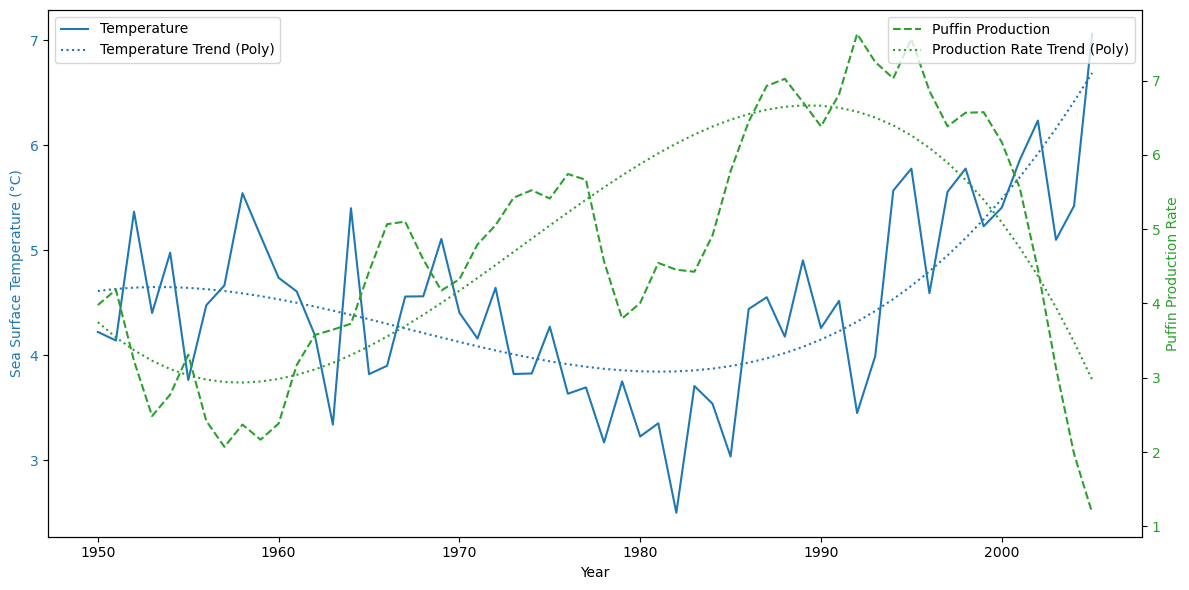

In [54]:
# Visualize temperature and production rate over the years
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on Y-axis 1
ax1.set_xlabel("Year")
ax1.set_ylabel("Sea Surface Temperature (°C)", color="tab:blue")
ax1.plot(cleaned_data['time'], cleaned_data['TOS'], color="tab:blue", label="Temperature")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Add a second Y-axis for the puffin production rate
ax2 = ax1.twinx()  # Share the X-axis
ax2.set_ylabel("Puffin Production Rate", color="tab:green")
ax2.plot(cleaned_data['time'], cleaned_data['production_rate'], color="tab:green", label="Puffin Production", linestyle="--")
ax2.tick_params(axis="y", labelcolor="tab:green")

# Polynomial regression for the temperature
poly_temp = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
temp_years = cleaned_data['time'].values.reshape(-1, 1)
poly_temp.fit(temp_years, cleaned_data['TOS'])
temp_poly_trend = poly_temp.predict(temp_years)
ax1.plot(cleaned_data['time'], temp_poly_trend, color="tab:blue", linestyle=":", label="Temperature Trend (Poly)")

# Polynomial regression for the puffin production
poly_prod = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
poly_prod.fit(temp_years, cleaned_data['production_rate'])
prod_poly_trend = poly_prod.predict(temp_years)
ax2.plot(cleaned_data['time'], prod_poly_trend, color="tab:green", linestyle=":", label="Production Rate Trend (Poly)")

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()


Here, we've just transformed the matplotlib graph into a poltly graph for greater interactivity. This visualization format is more demanding in terms of storage, so to avoid interfering with the main, we've saved it in the ./results folder. This way, it's visible (only) on the local server. 

In [55]:
# Create Plotly figure
fig = go.Figure()

# Add temperature trace
fig.add_trace(go.Scatter(
    x=cleaned_data['time'], 
    y=cleaned_data['TOS'], 
    mode='lines+markers', 
    name='Sea Surface Temperature (°C)',
    line=dict(color='blue'),
    marker=dict(color='blue')
))

# Add temperature polynomial trend
fig.add_trace(go.Scatter(
    x=cleaned_data['time'], 
    y=temp_poly_trend, 
    mode='lines', 
    name='Temperature Trend (Poly)',
    line=dict(color='blue', dash='dot')
))

# Add puffin production trace
fig.add_trace(go.Scatter(
    x=cleaned_data['time'], 
    y=cleaned_data['production_rate'], 
    mode='lines+markers', 
    name='Puffin Production Rate',
    line=dict(color='green', dash='dash'),
    marker=dict(color='green')
))

# Add puffin production polynomial trend
fig.add_trace(go.Scatter(
    x=cleaned_data['time'], 
    y=prod_poly_trend, 
    mode='lines', 
    name='Production Rate Trend (Poly)',
    line=dict(color='green', dash='dot')
))

# Update layout
fig.update_layout(
    title="Temperature and Puffin Production Rate Over the Years",
    xaxis_title="Year",
    yaxis=dict(title="Sea Surface Temperature (°C)", titlefont=dict(color="blue")),
    yaxis2=dict(
        title="Puffin Production Rate",
        overlaying="y",
        side="right",
        titlefont=dict(color="green")
    ),
    legend=dict(x=0, y=1, bgcolor="rgba(255, 255, 255, 0)", bordercolor="rgba(0, 0, 0, 0)"),
    template="plotly_white"
)

output_path = os.path.join(results_dir, "polynomial_reg_TOS_puffin.html")
fig.write_html(output_path)


### ☞ About **Polynomial Regression**

Polynomial regression is a fitting method that uses a polynomial (instead of a straight line) to model a relationship between variables. This makes it easier to capture non-linear relationships in the data.

#### Pipeline for Polynomial Regression
A pipeline is used to link two main steps:
- Polynomial transformation of the data. 
- A linear regression that fits a model to the transformed data. This enables non-linear relationships to be modeled efficiently, while maintaining a clear workflow.

#### Data preparation and cleanup
- The years, extracted from the time column, are reformed into a column matrix using .reshape(-1, 1). This step is essential, as polynomial regression requires a specific input format. The associated temperature or production data are used as the target variable.
- The merged data (temperature and production) are cleaned by removing rows with missing values (NaN). This ensures that only complete observations are used to avoid errors or biases in model training.

#### Model fitting and trend prediction
- The pipeline is then fitted to the input data using the .fit() method. This trains the model to learn how to predict the target variable (temperature or production) over time.
- Once trained, the model is used to predict trend values with .predict(). This produces smooth curves representing the general relationship between variables over time.

## 🔮 3. Prediction of the puffin population in the next years in Vestmann Islands regarding sea surface temperature predictions

As the article mentions that the relationship between puffin population and sea surface temperature is not linear, we will initially use a random forest model to predict the puffin population in the coming years on the Vestmann Islands.

### 3.1. Preparation and cleaning of data for merging 🤝

We have already prepared our data in section 2.1 of part 2. Let's visualize the data

Cleaned data overview:
   time       TOS  production_rate
0  1950  4.220461            3.979
1  1951  4.138985            4.184
2  1952  5.365545            3.226
3  1953  4.400865            2.485
4  1954  4.975276            2.773
Missing values in y: 0
Rows after cleaning: 56
Correlation between TOS and production_rate: -0.13075382860334872


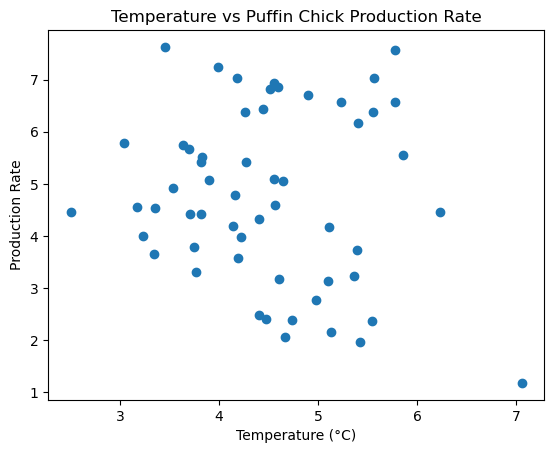

In [56]:
# Assume cleaned_data is already loaded and prepared
# cleaned_data contains 'TOS' and 'production_rate'

# Check the structure of cleaned_data
print("Cleaned data overview:")
print(cleaned_data.head())

# Prepare the data for the model
X = cleaned_data[['TOS']]  # Temperature
y = cleaned_data['production_rate']  # Production rate

# Check for missing values in y
print("Missing values in y:", y.isnull().sum())


print(f"Rows after cleaning: {len(cleaned_data)}")

correlation = cleaned_data['TOS'].corr(cleaned_data['production_rate'])
print("Correlation between TOS and production_rate:", correlation)

# Visualize the data
plt.scatter(cleaned_data['TOS'], cleaned_data['production_rate'])
plt.title("Temperature vs Puffin Chick Production Rate")
plt.xlabel("Temperature (°C)")
plt.ylabel("Production Rate")
plt.show()




### Predicting with regression

Linear Regression R²: -0.1991638078668183
Linear Regression MSE: 2.8219429234065436
Polynomial Regression R²: -0.17708720301708714
Polynomial Regression MSE: 2.769990956194187


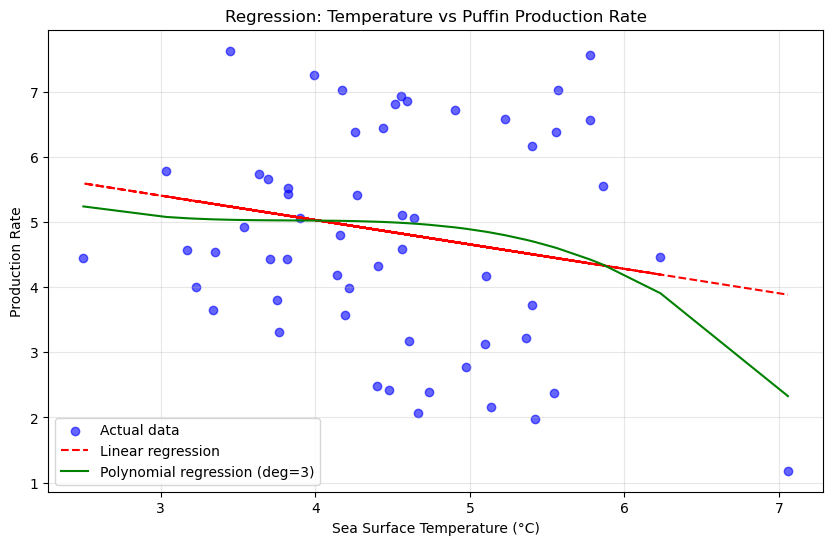

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Assuming cleaned_data contains 'TOS' (temperature) and 'production_rate'
# Prepare the features and target variable
X = cleaned_data[['TOS']]  # Features (Temperature of Surface)
y = cleaned_data['production_rate']  # Target variable (Production Rate)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)  # Train with training data
y_pred_linear = linear_model.predict(X_test)  # Predict on test data

# Print metrics for Linear Regression
print("Linear Regression R²:", r2_score(y_test, y_pred_linear))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_linear))

# Polynomial Regression (degree 3)
poly_features = PolynomialFeatures(degree=3)
X_poly_train = poly_features.fit_transform(X_train)  # Apply PolynomialFeatures on the training data
X_poly_test = poly_features.transform(X_test)  # Apply PolynomialFeatures on the test data

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)  # Train the polynomial regression model
y_pred_poly = poly_model.predict(X_poly_test)  # Predict on test data

# Print metrics for Polynomial Regression
print("Polynomial Regression R²:", r2_score(y_test, y_pred_poly))
print("Polynomial Regression MSE:", mean_squared_error(y_test, y_pred_poly))

# Visualization
plt.figure(figsize=(10, 6))

# Plot actual data points
plt.scatter(X, y, color='blue', alpha=0.6, label='Actual data')

# Linear regression line
plt.plot(X, linear_model.predict(X), color='red', linestyle='--', label='Linear regression')

# Polynomial regression line
sorted_indices = np.argsort(X['TOS'].values)  # Sort indices for a smooth curve
plt.plot(X['TOS'].values[sorted_indices], poly_model.predict(poly_features.transform(X.iloc[sorted_indices])), color='green', linestyle='-', label='Polynomial regression (deg=3)')

# Labels and legend
plt.title("Regression: Temperature vs Puffin Production Rate")
plt.xlabel("Sea Surface Temperature (°C)")
plt.ylabel("Production Rate")
plt.legend()
plt.grid(alpha=0.3)

# Display the plot
plt.show()

## Linear Regression Model Results

### 1. **R² (R-squared) = -0.199**
   - **What is R²?**
     R² (R-squared) is a statistical measure that represents the proportion of the variance in the dependent variable that can be predicted from the independent variable (sea surface temperature, TOS). 
     - **R² = 1**: Perfect fit, meaning the model explains all the variability in the data.
     - **R² = 0**: The model doesn't explain any variability, so the predictions are no better than just using the mean of the target variable.
     - **Negative R²**: This indicates that the model is worse than just predicting the mean of the target variable for all data points. The model's predictions are not only inaccurate but worse than a basic mean prediction.

   - **Why is R² negative?**
     A negative R² means that the Linear Regression model is performing poorly.  Some potential reasons for a negative R² in this case might be:
     - **No linear relationship**: The relationship between temperature (TOS) and puffin production rate may not be linear, and a linear model is not the best fit for the data.
     - **Outliers or noise**: If your data contains extreme values (outliers) or a lot of noise, the linear model may struggle to find a meaningful relationship.
     - **Insufficient data or features**: If the model is based on too few features (in this case, just TOS), it might fail to capture the complexities of the data.

### 2. **MSE (Mean Squared Error) = 2.822**
   - **What is MSE?**
     The MSE measures the average squared difference between the observed actual outcomes (true values) and the values predicted by the model. The lower the MSE, the better the model.
     - A **lower MSE** suggests that the model is making more accurate predictions.
     - A **higher MSE** indicates that the predictions are far off from the actual values.
  
   - **Interpretation of MSE = 2.822**:
     This high MSE suggests that your predictions are not very accurate.


We observe similar results with the polynomial regression
   


## Let's try to predict chick production trhrough time according to sea surface temperature

Even if the results are bad, let's try to predict chick production trhrough time according to sea surface temperature. If we can obtain better data, the process may be useful.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# ################### Cleaning the Data ####################

# Load historical temperature data (CSV)
nc_file = "projet_python_2024_ENSAE/data/cds_data_treated/tos_historical_data.csv"
temperature = pd.read_csv(nc_file)

# Ensure 'time' is in datetime format
temperature['Time'] = pd.to_datetime(temperature['Time'])
temperature['time'] = temperature['Time'].dt.year

# Calculate annual mean temperatures
temperature = temperature.groupby('time', as_index=False).agg({'TOS': 'mean'})

# Load puffin data (CSV)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Merge temperature and puffin production data
merged_data = pd.merge(temperature, puffins[['time', 'production_rate']], on="time", how="inner")
merged_data = merged_data.dropna()

# ################### Model Training and Prediction ####################

# Fit Polynomial Regression Model on Historical Data
degree = 3  # Polynomial degree
coeffs = np.polyfit(merged_data['TOS'], merged_data['production_rate'], degree)
poly_model = Polynomial(coeffs[::-1])  # Polynomial model

# Load future temperature data (CSV)
future_nc_file = "projet_python_2024_ENSAE/data/cds_data_treated/tos_ssp126_data.csv"
future_temperature = pd.read_csv(future_nc_file)

# Ensure 'time' is in datetime format
future_temperature['Time'] = pd.to_datetime(future_temperature['Time'])
future_temperature['time'] = future_temperature['Time'].dt.year

# Calculate annual mean temperatures for future data
future_temperature = future_temperature.groupby('time', as_index=False).agg({'TOS': 'mean'})

# Predict Puffin Production for Future Temperatures
future_temperature['predicted_production'] = poly_model(future_temperature['TOS'])

# ################### Visualization ####################

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot historical data
ax1.set_xlabel("Year")
ax1.set_ylabel("Sea Surface Temperature (°C)", color="tab:blue")
ax1.plot(merged_data['time'], merged_data['TOS'], color="tab:blue", label="Historical Temperature")
ax1.plot(future_temperature['time'], future_temperature['TOS'], color="tab:cyan", linestyle="--", label="Future Temperature")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Add secondary axis for puffin production
ax2 = ax1.twinx()
ax2.set_ylabel("Puffin Production Rate", color="tab:green")
ax2.plot(merged_data['time'], merged_data['production_rate'], color="tab:green", label="Historical Production")
ax2.plot(future_temperature['time'], future_temperature['predicted_production'], color="tab:orange", linestyle="--", label="Predicted Production")
ax2.tick_params(axis="y", labelcolor="tab:green")

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Add title and grid
fig.suptitle("Puffin Production Prediction Based on Future Temperature", fontsize=14)
ax1.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()

# Show plot
plt.show()

# ################### Results ####################

# Display predicted production for the first few years
print("Future Temperature and Predicted Production:")
print(future_temperature[['time', 'TOS', 'predicted_production']].head())



FileNotFoundError: [Errno 2] No such file or directory: 'projet_python_2024_ENSAE/data/cds_data_treated/tos_historical_data.csv'

## Let's try another model, Random forest

### ☞ About **Random Forest Regression**

Random Forest Regression is an ensemble learning method that uses multiple decision trees to improve prediction accuracy and avoid overfitting. Instead of relying on a single decision tree, Random Forest builds many trees, each trained on a random subset of the data and features, and then combines their outputs. This method helps capture complex, non-linear relationships between variables, making it a powerful tool for regression tasks, particularly when the data is noisy or has intricate patterns.

#### Pipeline for Random Forest Regression
A typical workflow for Random Forest Regression involves two key steps:
- **Data preparation**: The data is split into training and testing sets. Features (like temperature) and target variables (such as puffin production rate) are separated for model training.
- **Model training and prediction**: The Random Forest model is trained using the training data, which involves creating multiple decision trees. After the model is trained, it predicts the target variable based on the input features, providing a robust estimate of the relationships in the data.

#### Data preparation and cleanup
- The data is split into training and testing sets using methods like `train_test_split`, ensuring the model is trained on a portion of the data and tested on another portion to evaluate its performance.
- Any missing values are handled (e.g., through imputation or removal), and the features and target variable are separated.

#### Model fitting and performance evaluation
- The Random Forest model is trained on the training data using the `.fit()` method. This step builds multiple decision trees that learn different aspects of the data.
- After training, predictions are made using the `.predict()` method on the test data, and performance metrics such as R² and Mean Squared Error (MSE) are computed to evaluate the model's accuracy.
- Visualizations, such as scatter plots comparing predictions to actual observations, are often used to assess how well the model performs. 

This method is particularly effective for datasets with complex relationships, making Random Forest Regression a popular choice for modeling real-world data with non-linear patterns.

R²: -0.2826557121368758
Mean Squared Error: 3.0184209915995357


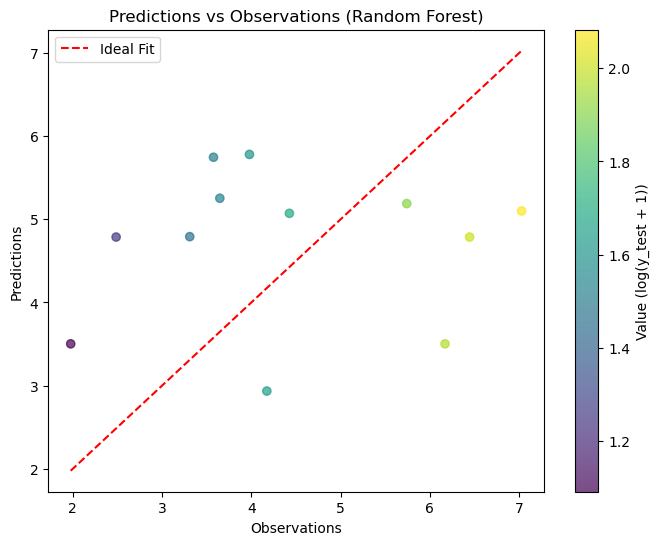

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Metrics
print("R²:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Visualize predictions vs observations
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c=np.log1p(y_test), cmap='viridis', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit")
plt.title("Predictions vs Observations (Random Forest)")
plt.xlabel("Observations")
plt.ylabel("Predictions")

# Add color bar
cbar = plt.colorbar()
cbar.set_label('Value (log(y_test + 1))')

plt.legend()
plt.show()


### **Analysis of Random Forest Model Results**

- **R²: -0.283**  
  A negative R² value indicates that the model performs worse than simply predicting the mean value of the target variable. This suggests poor predictive power and a failure to capture the underlying patterns in the data.

- **Mean Squared Error (MSE): 3.018**  
  A high MSE value suggests that the model's predictions are significantly off from the actual values, reinforcing the poor performance indicated by the negative R².

### **Possible Issues**
- **Overfitting/Underfitting**: The model might not be properly tuned.
- **Data Quality**: Noise or irrelevant features could be affecting the results.
- **Insufficient Data**: The model may not have enough data to learn effectively.

### **Next Steps**
- **More Data**: More data could help the model generalize better.

In conclusion, improvements are needed in the model tuning and data handling to achieve better results.

### Random forest model and predictions

Let's try to do predictions even with our poor data quality. 

Scenario 1 (Temperature = 5.49°C): Predicted Production Rate = 3.54
Scenario 2 (Temperature = 6.49°C): Predicted Production Rate = 3.75
Scenario 3 (Temperature = 7.49°C): Predicted Production Rate = 1.90


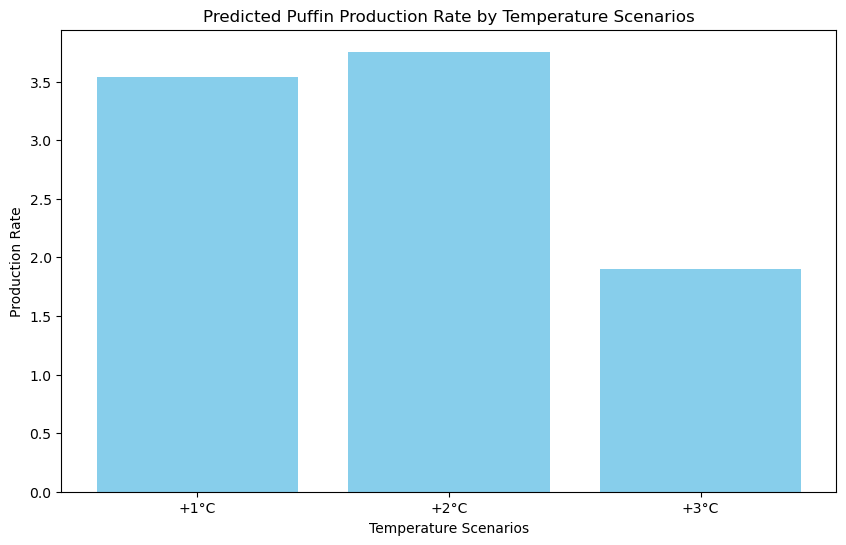

In [ ]:
# Temperature scenarios
future_scenarios = pd.DataFrame({
    'TOS': [X['TOS'].mean() + 1, X['TOS'].mean() + 2, X['TOS'].mean() + 3]  # Remplacez 'tos' par 'TOS'
})


# Predictions for the scenarios
future_predictions = rf_model.predict(future_scenarios)

# Display predictions
for i, scenario in enumerate(future_scenarios['TOS']):
    print(f"Scenario {i+1} (Temperature = {scenario:.2f}°C): Predicted Production Rate = {future_predictions[i]:.2f}")

# Visualize predictions for the scenarios
plt.figure(figsize=(10, 6))
plt.bar(['+1°C', '+2°C', '+3°C'], future_predictions, color='skyblue')
plt.title("Predicted Puffin Production Rate by Temperature Scenarios")
plt.ylabel("Production Rate")
plt.xlabel("Temperature Scenarios")
plt.show()

### Evaluating the performance of the model

In [27]:
# Evaluate performance

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 3.02
R² Score: -0.28


### Analize of the results

The results show that the Random Forest model is not performing well:

- **High MSE**: A high Mean Squared Error value indicates that the model is making significant errors in its predictions.  
- **Negative R²**: This means that the model performs worse than simply predicting the mean of the observations (in other words, it is useless in its current state).


## Let's try to fix the random forest model

Cross-validated R² scores: [-15.54452368  -4.32652702  -0.29444212 -11.0885111   -0.38007449]
Average R²: -6.326815683221851
Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


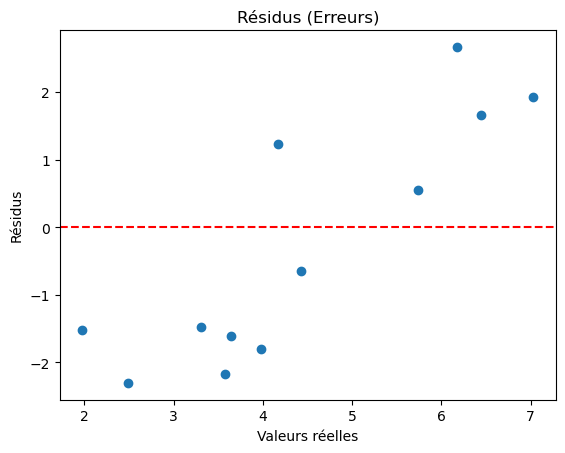

In [28]:

#cross-validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Average R²:", scores.mean())

#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus (Erreurs)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus")
plt.show()


Let's do the same but let's try to predict puffin population according to the different copernicus scenarios.

Predictions for scenario ssp126:
    Year       TOS  Predicted_Production
0  2015  5.668837              6.742773
1  2016  6.196030              5.006463
2  2017  5.420147              3.502466
3  2018  8.238452              1.902360
4  2019  7.052710              1.902360
Predictions for scenario ssp245:
    Year       TOS  Predicted_Production
0  2015  5.578661              5.379727
1  2016  6.223299              5.006463
2  2017  5.915995              5.797763
3  2018  6.609746              3.754773
4  2019  6.513638              3.754773
Predictions for scenario ssp585:
    Year       TOS  Predicted_Production
0  2015  6.036432              5.486503
1  2016  5.873781              5.797763
2  2017  6.262249              5.006463
3  2018  6.185033              5.006463
4  2019  6.548025              3.754773


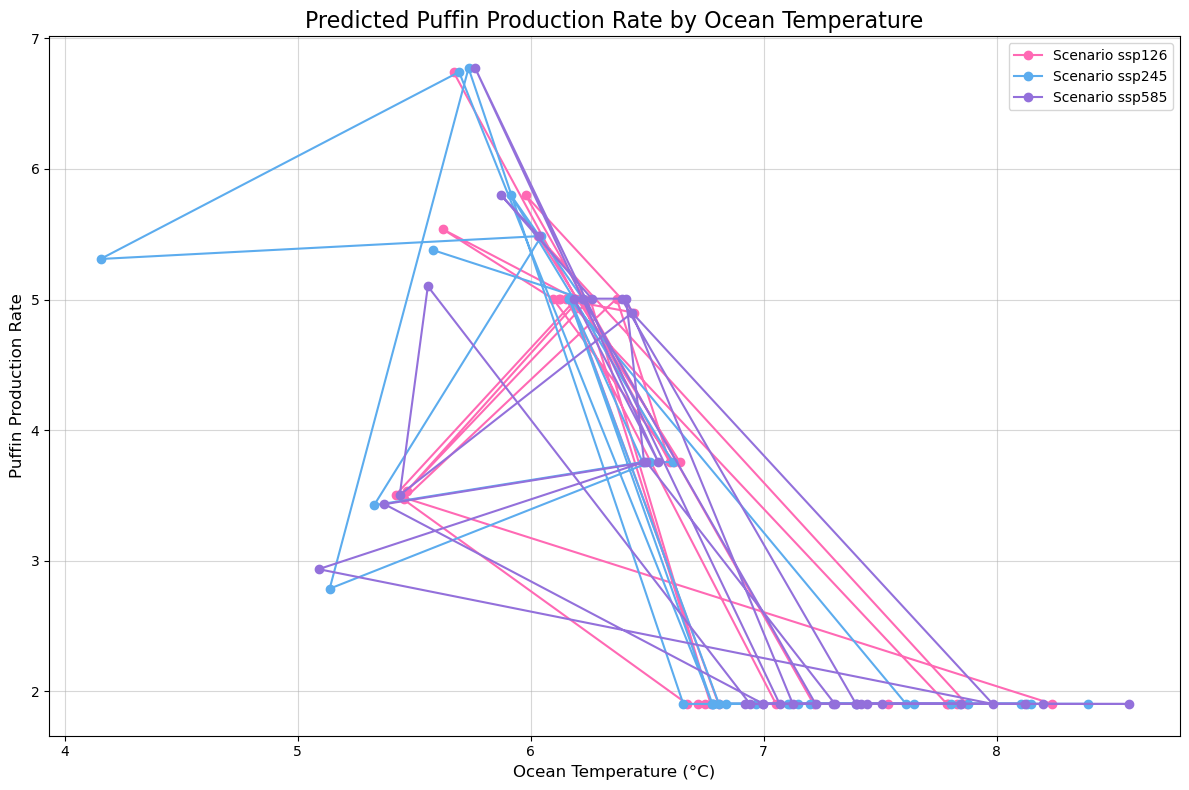

In [ ]:
# Dictionary to store prediction results
scenario_predictions = {}

# Dictionary for assigning colors to each scenario
scenario_colors = {
    "ssp126": "#FF69B4",  # Darker Pink
    "ssp245": "#5CACEE",  # Darker Blue
    "ssp585": "#9370DB"   # Darker Purple
}

# Iterate over each scenario in the data
for scenario, df in scenario_dataframes.items():
    # Convert dates to years
    df['Year'] = pd.to_datetime(df['Time']).dt.year
    
    # Calculate annual mean temperatures
    annual_mean_df = df.groupby('Year', as_index=False).agg({'TOS': 'mean'})
    
    # Make predictions for each annual temperature
    annual_mean_df['Predicted_Production'] = rf_model.predict(annual_mean_df[['TOS']])
    
    # Store the predictions in the dictionary
    scenario_predictions[scenario] = annual_mean_df
    
    # Print a preview of the results
    print(f"Predictions for scenario {scenario}:\n", annual_mean_df.head())

# Visualize the predictions for each scenario (based on temperatures)
plt.figure(figsize=(12, 8))

for scenario, df in scenario_predictions.items():
    plt.plot(df['TOS'], df['Predicted_Production'], marker='o', label=f"Scenario {scenario}", color=scenario_colors[scenario])

# Add titles and labels
plt.title("Predicted Puffin Production Rate by Ocean Temperature", fontsize=16)
plt.xlabel("Ocean Temperature (°C)", fontsize=12)
plt.ylabel("Puffin Production Rate", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()



We can observe that above a certain temperature that is about 6.5°C, the chick production drop. According to [Global Change Biology, Hansen et al. (2021)](https://onlinelibrary.wiley.com/doi/10.1111/gcb.15665), the chick production is supposed to reach a peak at 7,09°C. However, in the article they use other covariates such as AMO (Atlantic Multidecadal Oscillation) or NAO (North Atlantic Oscillation) which can also impact the chick production. This may explain the difference between our results and [Global Change Biology, Hansen et al. (2021)](https://onlinelibrary.wiley.com/doi/10.1111/gcb.15665)'s results.

### Sample through a "puffin year" (September to August)

We try another sample of data with a year that follow the puffin breading season from september to august.

In [ ]:
import pandas as pd

# Load CSV data (temperatures)
tos_df = pd.read_csv("data/cds_data_treated/tos_historical_data.csv")

# Convert 'Time' to datetime format
tos_df['Time'] = pd.to_datetime(tos_df['Time'])

# Adjust 'Time' to align months before September to the previous year
tos_df['Time'] = tos_df['Time'].where(tos_df['Time'].dt.month >= 9, tos_df['Time'] - pd.Timedelta(days=365))

# Create the 'season_year' column based on the adjusted 'Time'
tos_df['season_year'] = tos_df['Time'].dt.year

# Calculate the annual mean of TOS, grouped by season_year
tos_df = tos_df.groupby('season_year', as_index=False).agg({'TOS': 'mean'})

# Load CSV data (puffin production rates)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")

# Rename the 'Year' column to 'time' to match the temperature column
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Merge data on the 'season_year' column (inner join)
merged_data = pd.merge(tos_df, puffins[['time', 'production_rate']], left_on="season_year", right_on="time", how="inner")

# Clean data: remove rows with missing values (NaNs)
cleaned_data = merged_data.dropna()

# Save the cleaned data to a new CSV file
cleaned_data.to_csv("cleaned_data_season.csv", index=False)

# Print a confirmation message
print("Cleaned data has been saved to 'cleaned_data_season.csv'")

<string>:7: FutureWarning:

'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.

<string>:7: FutureWarning:

'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.



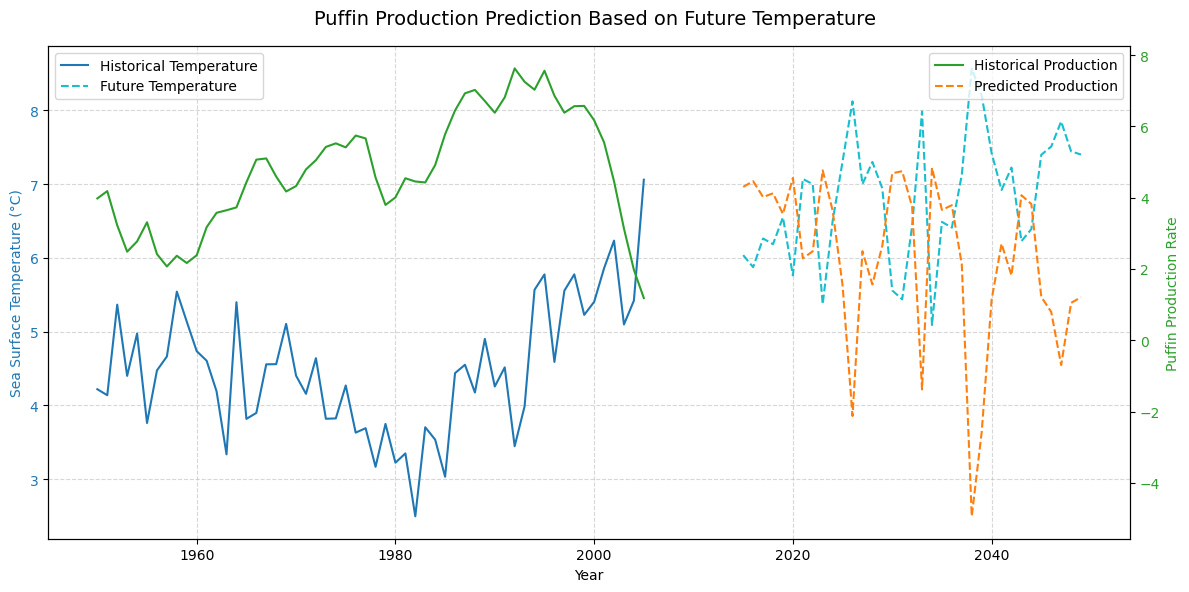

Future Temperature and Predicted Production:
   time       tos  predicted_production
0  2015  6.036432              4.301198
1  2016  5.873781              4.462589
2  2017  6.262249              4.016476
3  2018  6.185034              4.122227
4  2019  6.548025              3.542371


In [60]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# ################### Cleaning the Data ####################

# Load NetCDF data (temperatures)
nc_file = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc"
data = xr.open_dataset(nc_file)

# Annual mean temperatures
temperature = data['tos'].resample(time="1Y").mean().to_dataframe()
temperature.reset_index(inplace=True)

# Convert 'time' to full years (int64)
temperature['time'] = temperature['time'].astype(str)
temperature['time'] = pd.to_datetime(temperature['time'])
temperature['time'] = temperature['time'].dt.year.astype('int64')

# Load puffin data (CSV)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Merge temperature and puffin production data
merged_data = pd.merge(temperature, puffins[['time', 'production_rate']], on="time", how='inner')
merged_data = merged_data.dropna()

# ################### Model Training and Prediction ####################

# Fit Polynomial Regression Model on Historical Data
degree = 3  # Polynomial degree
coeffs = np.polyfit(merged_data['tos'], merged_data['production_rate'], degree)
poly_model = Polynomial(coeffs[::-1])  # Polynomial model

# Load Future Temperature Data
future_nc_file = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20150116-20491216.nc"
future_data = xr.open_dataset(future_nc_file)

# Calculate annual mean for future temperatures
future_temperature = future_data['tos'].resample(time="1Y").mean().to_dataframe()
future_temperature.reset_index(inplace=True)
future_temperature['time'] = future_temperature['time'].astype(str)
future_temperature['time'] = pd.to_datetime(future_temperature['time'])
future_temperature['time'] = future_temperature['time'].dt.year.astype('int64')

# Predict Puffin Production for Future Temperatures
future_temperature['predicted_production'] = poly_model(future_temperature['tos'])

# ################### Visualization ####################

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot historical data
ax1.set_xlabel("Year")
ax1.set_ylabel("Sea Surface Temperature (°C)", color="tab:blue")
ax1.plot(merged_data['time'], merged_data['tos'], color="tab:blue", label="Historical Temperature")
ax1.plot(future_temperature['time'], future_temperature['tos'], color="tab:cyan", linestyle="--", label="Future Temperature")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Add secondary axis for puffin production
ax2 = ax1.twinx()
ax2.set_ylabel("Puffin Production Rate", color="tab:green")
ax2.plot(merged_data['time'], merged_data['production_rate'], color="tab:green", label="Historical Production")
ax2.plot(future_temperature['time'], future_temperature['predicted_production'], color="tab:orange", linestyle="--", label="Predicted Production")
ax2.tick_params(axis="y", labelcolor="tab:green")

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Add title and grid
fig.suptitle("Puffin Production Prediction Based on Future Temperature", fontsize=14)
ax1.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()

# Show plot
plt.show()

# ################### Results ####################

# Display predicted production for the first few years
print("Future Temperature and Predicted Production:")
print(future_temperature[['time', 'tos', 'predicted_production']].head())


Evaluation Metrics on Test Data:
 - MSE (Mean Squared Error): 2.77
 - RMSE (Root Mean Squared Error): 1.66
 - R² (Coefficient of Determination): -0.18


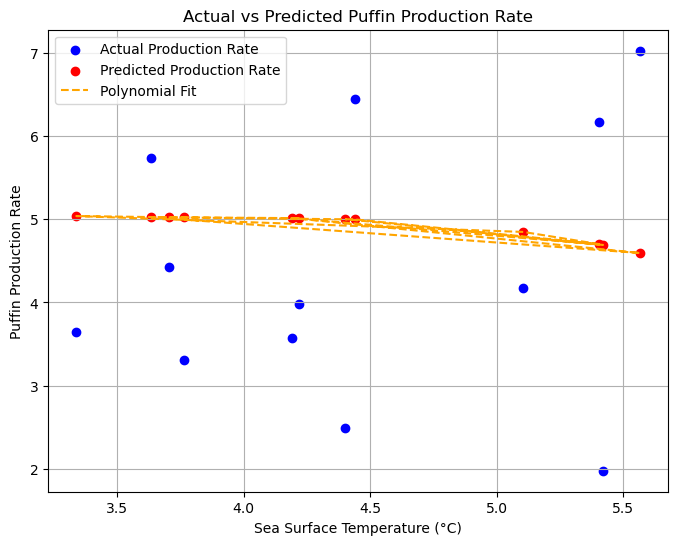

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ################### Split Data into Training and Test Sets ####################

# Split merged_data into training (80%) and testing (20%) sets
X = merged_data['tos'].values.reshape(-1, 1)  # Temperature values
y = merged_data['production_rate'].values  # Production rates

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ################### Train Polynomial Regression Model ####################

# Fit Polynomial Regression Model on Training Data
degree = 3  # Polynomial degree
coeffs = np.polyfit(X_train.flatten(), y_train, degree)  # Fit on training data
poly_model = Polynomial(coeffs[::-1])  # Reverse coeffs for Polynomial function

# ################### Predict on Test Data ####################

# Predict production rates for the test data
y_pred = poly_model(X_test.flatten())

# ################### Evaluate Model Performance ####################

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R² (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

# Print Evaluation Metrics
print(f"Evaluation Metrics on Test Data:")
print(f" - MSE (Mean Squared Error): {mse:.2f}")
print(f" - RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f" - R² (Coefficient of Determination): {r2:.2f}")

# ################### Visualize Predicted vs Actual ####################

# Plot actual vs predicted production rates on test data
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color="blue", label="Actual Production Rate")
plt.scatter(X_test, y_pred, color="red", label="Predicted Production Rate")
plt.plot(X_test, y_pred, color="orange", linestyle="--", label="Polynomial Fit")
plt.xlabel("Sea Surface Temperature (°C)")
plt.ylabel("Puffin Production Rate")
plt.title("Actual vs Predicted Puffin Production Rate")
plt.legend()
plt.grid(True)
plt.show()
